In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import lsq_linear
from sklearn.linear_model import LinearRegression
import pickle
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline 

## Configuration

### Plotting styling

In [4]:
colors = {}
#Expert algos
colors['Threshold0'] = 'black'
colors['Threshold'] = 'black'
colors['Mixedbcstcsig5'] = 'red'

colors['AEttbar'] = 'tab:blue'
colors['AElphe'] = 'tab:blue'
colors['AElayers'] = 'tab:orange'

colors['AElayer9'] = 'tab:blue'
colors['AElayer11'] = 'tab:orange'

styles = {}
styles['Threshold0'] = '-'
styles['Threshold'] = '-.'
styles['Mixedbcstcsig5'] = '-.'
styles['AEttbar'] = '-'
styles['AElphe'] = '--'
styles['AElayers'] = '--'

styles['AElayer9'] = '-'
styles['AElayer11'] = '-'

legends = {}
legends['Threshold0'] = 'Truth'
legends['Threshold'] = 'Threshold 1.35 mipT'
legends['Mixedbcstcsig5'] = 'Real BC+STC 5' 

legends['AEttbar'] = 'ttbar'
legends['AElphe'] = 'AE Layer 9'
legends['AElayers'] = 'AE Layers 5,7,9,11'

legends['AElayer9'] = 'AE Layer 9 sim>0'
legends['AElayer11'] = 'AE Layer 11 sim>0'

ref_name = 'Threshold0'

### Input files and FE algorithms to be studied
Both 200PU electron gun and 0PU photon guns are loaded

In [5]:
version = 'hackathon_plots_2'

fig_dir = '/home/cms.rshenoy/Plots/{}'.format(version)

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [6]:
algo_files = {}

# Read  old FE set
directory_tele = '/home/cms.rshenoy/09_26_22_tele/electron_photon_signaldriven/v_1_2022-09-27'
directory_emd = '/home/cms.rshenoy/09_03_22_updates/electron_photon_signaldriven/v_1_2022-09-03'

directory_1 = '/home/cms.rshenoy/10_10_22/electron_photon_signaldriven/v_1_2022-10-11'
directory_2 = '/home/cms.rshenoy/10_13_22/electron_photon_signaldriven/v_1_2022-10-14'


fes = ['AElphe','Mixedbcstcsig5','AElayers','AElayer9','AElayer11']

for fe in fes:
    if fe == 'AElphe' or fe== 'Mixedbcstcsig5' or fe== 'AElayers':
        algo_files[fe] = (glob(directory_1+'/electrons/*.hdf5'), glob(directory_1+'/photons/*.hdf5'))
    else:
        algo_files[fe] = (glob(directory_2+'/electrons/*.hdf5'), glob(directory_2+'/photons/*.hdf5'))


## Loading and preprocessing dataframes

In [7]:
#load electrons and photons

algos_dfs = {}
for fe,files in algo_files.items():
    name = fe
    dfs = []
    for file in files[0]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    for file in files[1]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    algos_dfs[fe] = pd.concat(dfs)
algo_names = sorted(algos_dfs.keys())

Selection cuts (in addition to those already applied before):
- Gen particle $p_T > 5 GeV$
- Cluster $p_T > 3 GeV$
- Extrapolated gen particle eta between 1.6 and 2.9

Additionally label electrons and positrons as `0` and photons as `1`.

In [8]:
ptcut=5
clptcut=3
etamin=1.6
etamax=2.9
algo_cut={}
for name,df in algos_dfs.items():
    sel = df['genpart_pt']>ptcut
    algo_cut[name] = df[sel]
    sel = algo_cut[name]['cl3d_pt']>clptcut
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])>etamin
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])<etamax
    algo_cut[name] = algo_cut[name][sel]
    sel = algo_cut[name]['matches']==True
    algo_cut[name] = algo_cut[name][sel]
    #algo_cut[name].dropna(inplace=True)
    algo_cut[name]['genpart_pid'].replace([-11,11],1, inplace=True)
    algo_cut[name]['genpart_pid'].replace([22],0, inplace=True)

In [9]:
for name,df in algo_cut.items():
    df['cl3d_abseta'] = np.abs(df.cl3d_eta)

## Energy corrections
### Layer weights
On 0PU photon clusters:
- Select layer pTs in the ECAL, dropping the first layer as it doesn't bring anything in the e/g energy and is polluted by PU
- Apply linear regression to find multiplicative coeff. to be applied to each layer pT. These coeff. are bounded between 0 and 2 to avoid large correction factors

In [10]:
layer_coeffs = {}
for name,df in algo_cut.items():
    print(name)
    # select layers [2,14]
    select = df.query('genpart_pid==0')
    layers = np.array(select['cl3d_layer_pt'].tolist())[:,2:15]
    regression = lsq_linear(layers, select['genpart_pt'],
                              bounds = (0.,2.0),
                              method='bvls',
                              lsmr_tol='auto',
                              verbose=1)
    layer_coeffs[name] = regression.x
    print(regression.x)

AElphe
The relative change of the cost function is less than `tol`.
Number of iterations 3, initial cost 1.4555e+05, final cost 1.3828e+05, first-order optimality 3.51e-08.
[1.53412687 0.98080527 1.04683006 1.04703701 1.01348249 1.09295672
 1.04553572 1.03196888 0.95218214 0.86304789 1.05883649 1.95532625
 2.        ]
Mixedbcstcsig5
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 1.2527e+05, final cost 1.1596e+05, first-order optimality 8.06e-09.
[1.75620018 0.95193648 1.06386141 1.0647204  1.02680519 1.21627693
 1.12529791 1.06577263 1.04472168 0.94182775 1.18862268 2.
 2.        ]
AElayers
The relative change of the cost function is less than `tol`.
Number of iterations 3, initial cost 1.2839e+05, final cost 1.2042e+05, first-order optimality 2.82e-08.
[1.60176147 0.97254243 1.04776342 1.05420066 1.02432177 1.08911202
 1.06685808 1.01684088 0.9644755  0.85133763 1.13858092 1.89182685
 2.        ]
AElayer9
The relative change of the co

Apply layer weights and compute ratios wrt the gen $p_T$ and plot the weight values

In [11]:
# Apply calibration
for name,df in algo_cut.items():
    layers = np.array(df['cl3d_layer_pt'].tolist())[:,2:15]
    df['cl3d_pt_calib'] = np.dot(layers, layer_coeffs[name])
    df['cl3d_over_gen_pt'] = df['cl3d_pt']/df['genpart_pt']
    df['calib_over_gen_pt'] = df['cl3d_pt_calib']/df['genpart_pt']

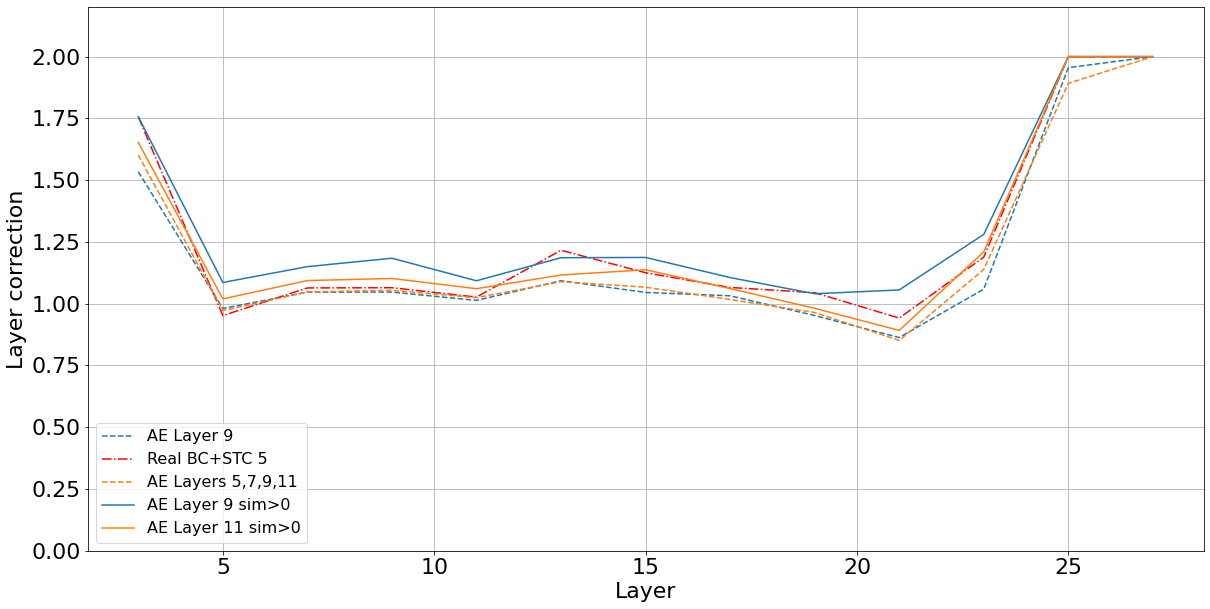

In [12]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
for name,weights in layer_coeffs.items():
    plt.plot(range(3, 29, 2), weights, label=legends[name], color=colors[name], ls=styles[name])
plt.ylim(0., 2.2)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('Layer')
plt.ylabel('Layer correction')
plt.savefig(fig_dir+'/layer_corrections.png')
plt.show()

Check impact of layer corrections on the energy ratio distributions

Raw mean=0.9501025676727295, rms=0.04061394929885864, rms/mean=0.04274690896272659
Calib mean=0.99498964887663, rms=0.045566463035101736, rms/mean=0.045795916657572766


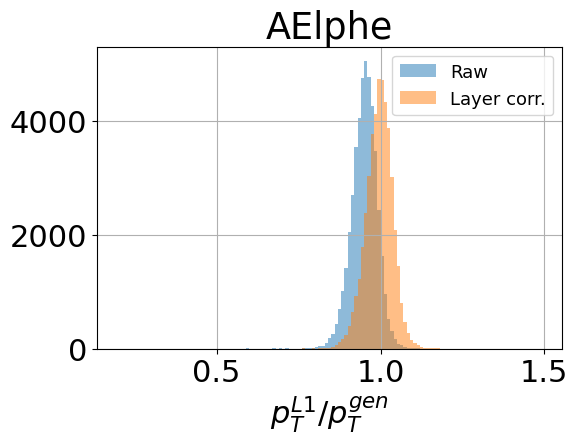

Raw mean=0.9149302840232849, rms=0.036418765783309937, rms/mean=0.039804961532354355
Calib mean=1.0024377000503617, rms=0.04283149026778187, rms/mean=0.04272733384391873


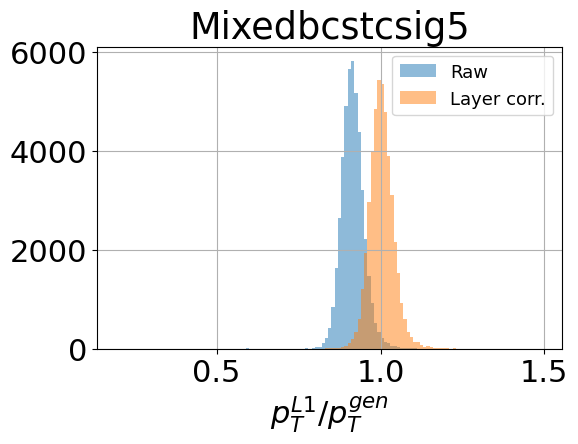

Raw mean=0.9454473257064819, rms=0.03785509243607521, rms/mean=0.04003934562206268
Calib mean=0.9951171593722251, rms=0.04301256954506094, rms/mean=0.04322362361050597


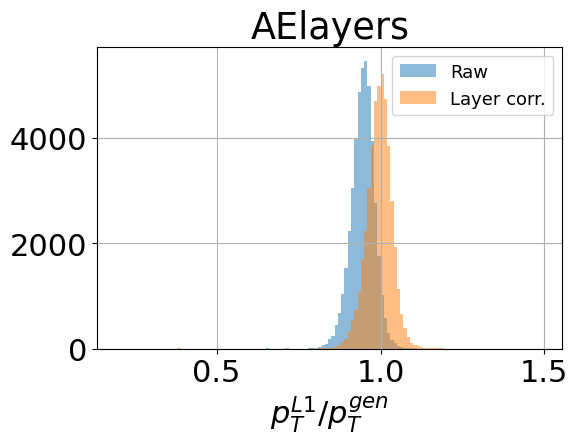

Raw mean=0.8614803552627563, rms=0.040345847606658936, rms/mean=0.046833161264657974
Calib mean=0.9960779524751654, rms=0.04934910373322537, rms/mean=0.049543415362820975


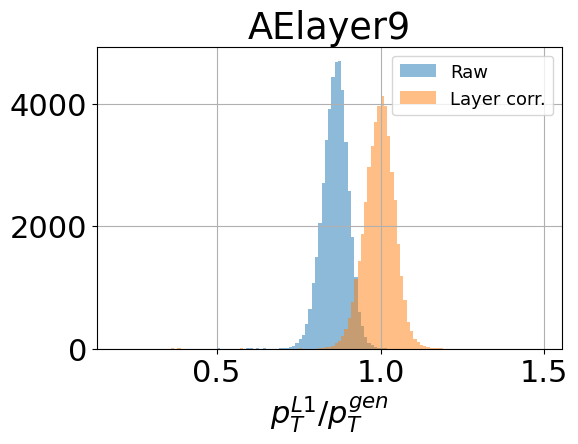

Raw mean=0.9082213640213013, rms=0.03875360265374184, rms/mean=0.04266977682709694
Calib mean=0.9954903122986501, rms=0.045418053152128456, rms/mean=0.04562380225203327


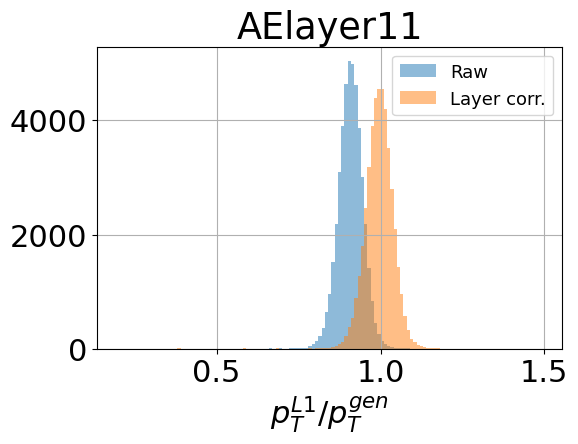

In [13]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==0')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Raw')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Layer corr.')
    plt.title(name)
    plt.legend(fontsize=13)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.grid()
    plt.savefig(fig_dir+'/energy_ratio_'+name+'.png')
    plt.show()

## eta correction
On 200PU electrons, on top of the layer correction.

Simple linear correction vs eta to correct for PU. This correction is additive, not multiplicative.

In [14]:
corrs = {}
corrs['eta'] = {}
for name,df in algo_cut.items():
    print('  '+name)
    select = df.query('genpart_pid==1')
    X = select[['cl3d_abseta']]
    y = select['genpart_pt']-select['cl3d_pt_calib']
    corrs['eta'][name] = LinearRegression().fit(X, y)

  AElphe
  Mixedbcstcsig5
  AElayers
  AElayer9
  AElayer11


Print correction value at eta=1.5 and eta=3

In [15]:
for name,df in algo_cut.items():
    corr = corrs['eta'][name]
    print(name)
    print('  eta=1.5:', corr.intercept_+corr.coef_*1.5)
    print('  eta=3:', corr.intercept_+corr.coef_*3)

AElphe
  eta=1.5: [5.6620235]
  eta=3: [-15.661179]
Mixedbcstcsig5
  eta=1.5: [5.1572704]
  eta=3: [-4.955901]
AElayers
  eta=1.5: [5.730892]
  eta=3: [-16.703167]
AElayer9
  eta=1.5: [5.44405]
  eta=3: [-16.336615]
AElayer11
  eta=1.5: [5.262932]
  eta=3: [-18.282028]


In [16]:
for name,df in algo_cut.items():
    df['cl3d_corr_eta'] = corrs['eta'][name].predict(df[['cl3d_abseta']])
    df['cl3d_pt_corr_eta'] =  df['cl3d_corr_eta']+df.cl3d_pt_calib
    df['corr_eta_over_gen_pt'] = df['cl3d_pt_corr_eta']/df['genpart_pt']    

Raw mean=1.0720546245574951, rms=0.20755240321159363, rms/mean=0.19360245764255524
Calib mean=1.1112500305417514, rms=0.19262941313332885, rms/mean=0.17334479895529817
Corr eta mean=0.9864176096227609, rms=0.1389215523424909, rms/mean=0.14083442041917638


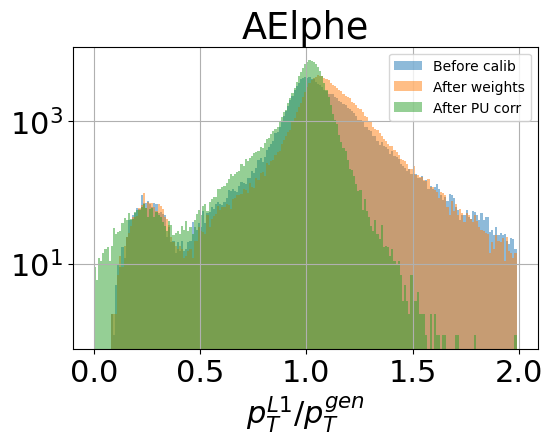

Raw mean=0.9334275722503662, rms=0.1265707015991211, rms/mean=0.13559778034687042
Calib mean=0.9986603508635336, rms=0.10992575018247226, rms/mean=0.11007320966274504
Corr eta mean=1.0024019770198898, rms=0.08594799420431988, rms/mean=0.0857420437855087


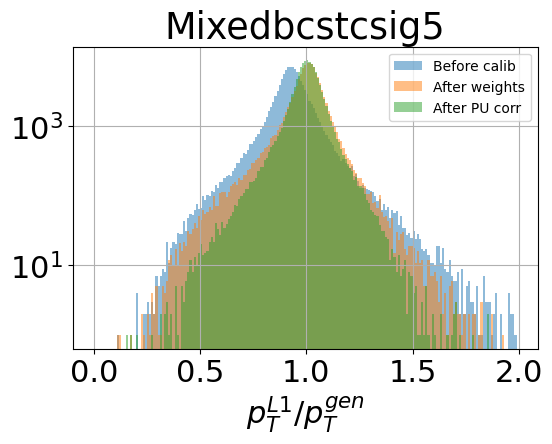

Raw mean=1.0758991241455078, rms=0.2143135666847229, rms/mean=0.19919484853744507
Calib mean=1.123143998045019, rms=0.20077273516525415, rms/mean=0.17875956735265086
Corr eta mean=0.9859998467203216, rms=0.14053405349715126, rms/mean=0.1425294881785247


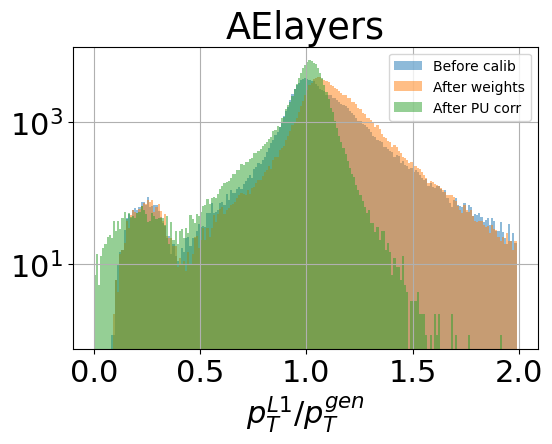

Raw mean=0.9809951186180115, rms=0.1898922175168991, rms/mean=0.19357101619243622
Calib mean=1.1238077521091645, rms=0.18945428787351, rms/mean=0.16858247108363672
Corr eta mean=0.9871626455635306, rms=0.1136974581805092, rms/mean=0.11517601348823729


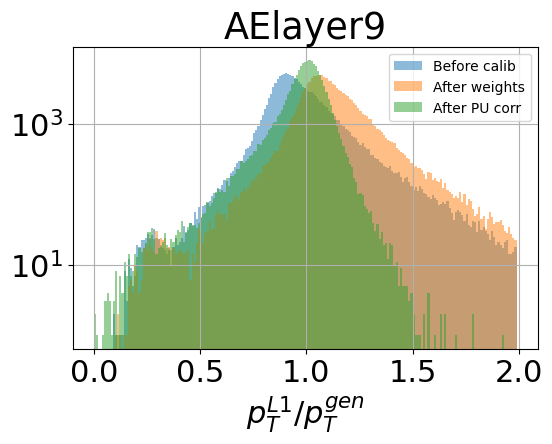

Raw mean=1.0552841424942017, rms=0.20851071178913116, rms/mean=0.1975872665643692
Calib mean=1.1469885577804233, rms=0.20036618321701413, rms/mean=0.17468891198422204
Corr eta mean=0.9835497907995262, rms=0.11985813260332748, rms/mean=0.12186280117643558


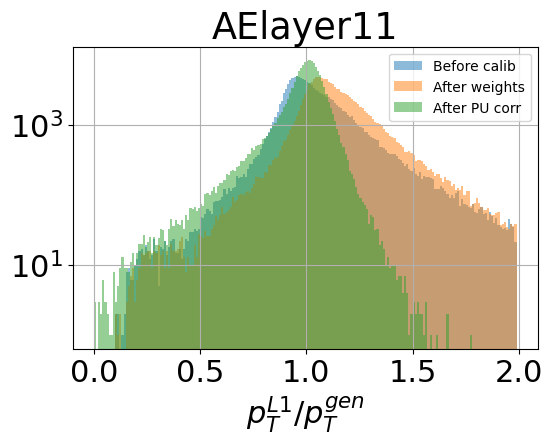

In [17]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    print('Corr eta mean={0}, rms={1}, rms/mean={2}'.format(
        select['corr_eta_over_gen_pt'].mean(),
        select['corr_eta_over_gen_pt'].std(),
        select['corr_eta_over_gen_pt'].std()/select['corr_eta_over_gen_pt'].mean()
    ))
    #plt.figure(figsize=(15,10))
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='Before calib')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After weights')
    plt.hist(select['corr_eta_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After PU corr')
    plt.grid()
    plt.legend(loc = 'upper right', fontsize=10)
    plt.yscale('log')
    plt.title(name)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.savefig(fig_dir+'/eta_corrections'+name+'.png')
    plt.show()

## Final plots
### For electrons with 200PU, looking at $p_T > 10\,GeV, |\eta| \in all$
First bin in eta and pT

In [18]:
binetasize = 0.1
binptsize = 5
for name, df in algo_cut.items():
    df['genpart_abseta'] = np.abs(df.genpart_exeta)
    df['genpart_bineta'] = (
        (df.genpart_abseta - etamin)/binetasize).astype('int32')
    df['genpart_binpt'] = (df.genpart_pt/binptsize).astype('int32')

Compute the mean, RMS, and effective RMS of the pT ratios in each eta and pT bin

In [19]:
def effrms(df, c=0.68):
    """Compute half-width of the shortest interval
    containing a fraction 'c' of items in a 1D array.
    """
    out = {}
    for col in df:
        x = df[col]
        x = np.sort(x, kind="mergesort")
        m = int(c * len(x)) + 1
        out[col] = [np.min(x[m:] - x[:-m]) / 2.0]
    return pd.DataFrame(out).iloc[0]

In [20]:
etameans = {} 
etarmss = {} 
etaeffrmss = {} 
ptmeans = {} 
ptrmss = {} 
pteffrmss = {}
both_means={}
both_eff_rms={}
both_full_rms={}
plot_var = ['genpart_pt', 'genpart_abseta',
            'genpart_bineta', 'genpart_binpt',
           'cl3d_pt', 'cl3d_abseta', 'cl3d_pt_calib',
           'cl3d_pt_corr_eta', 'cl3d_over_gen_pt',
           'calib_over_gen_pt', 'corr_eta_over_gen_pt']


for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    etameans[name] = select[plot_var].groupby('genpart_bineta').mean()
    etarmss[name] = select[plot_var].groupby('genpart_bineta').std()
    etaeffrmss[name] = select[plot_var].groupby('genpart_bineta').apply(effrms)
    ptmeans[name] = select[plot_var].groupby('genpart_binpt').mean()
    ptrmss[name] = select[plot_var].groupby('genpart_binpt').std()
    pteffrmss[name] = select[plot_var].groupby('genpart_binpt').apply(effrms)
    both_means[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).mean()
    both_eff_rms[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).apply(effrms)
    both_full_rms[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).std()

In [21]:
plotted_algo = fes

Mean vs eta


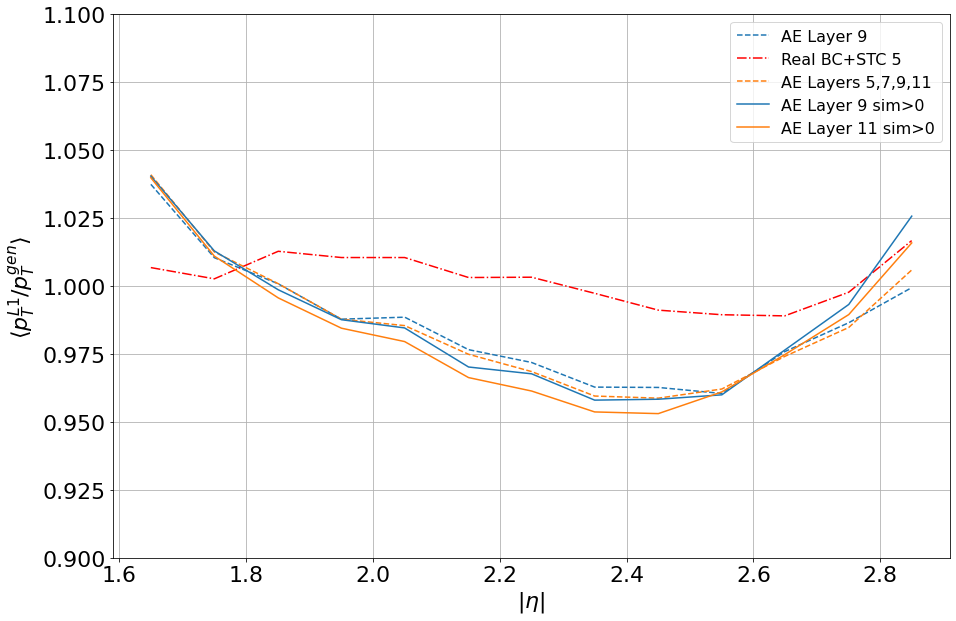

RMS vs eta


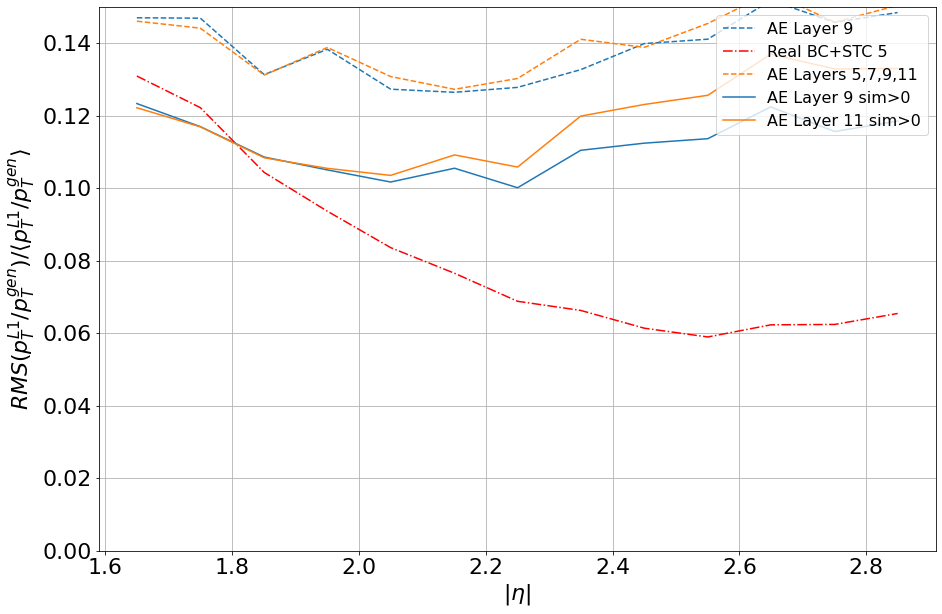

Eff RMS vs eta


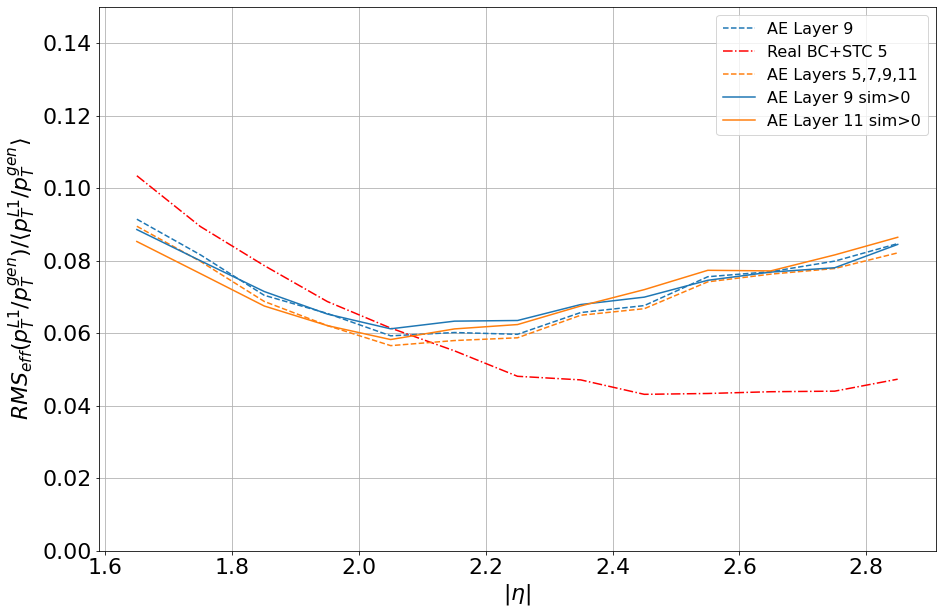

Mean vs pt


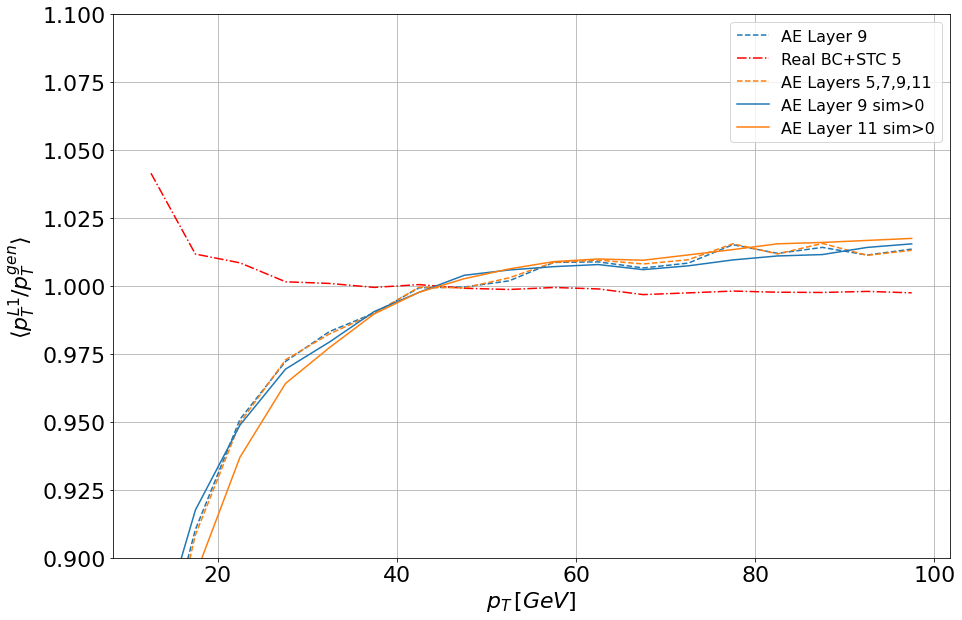

RMS vs pt


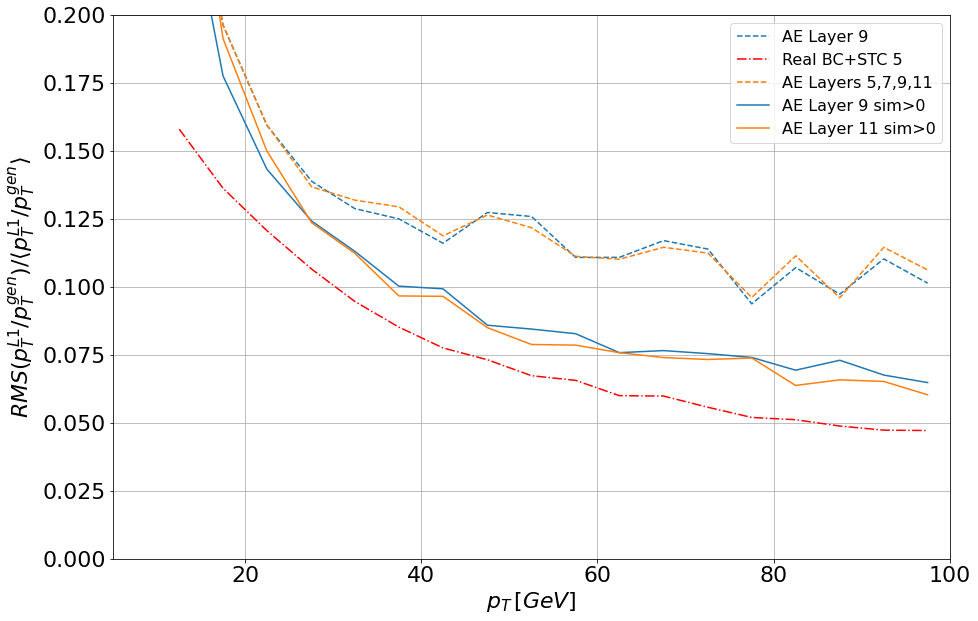

Eff RMS vs pt


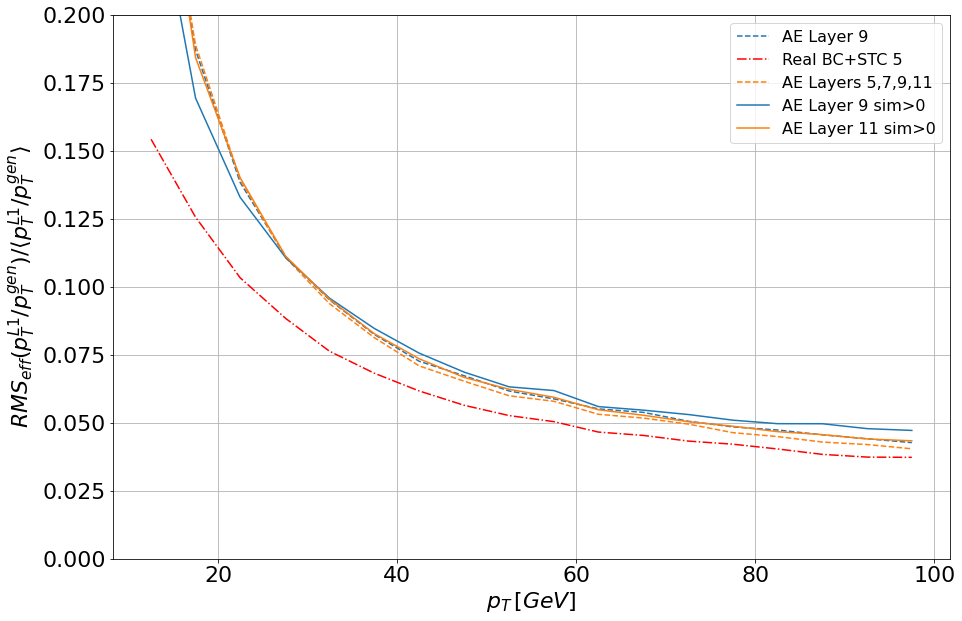

In [22]:
print('Mean vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/mean_v_eta.png')
plt.show()


print('RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etarmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.15)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/rms_v_eta.png')
plt.show()


print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.15)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/rms_eff_v_eta.png')
plt.show()


print('Mean vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/rms_eff_v_eta.png')
plt.show()


print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.xlim(5., 100)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/mean_v_pT.png')
plt.show()


print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/rms_eff_v_pT.png')
plt.show()

Eff RMS vs eta


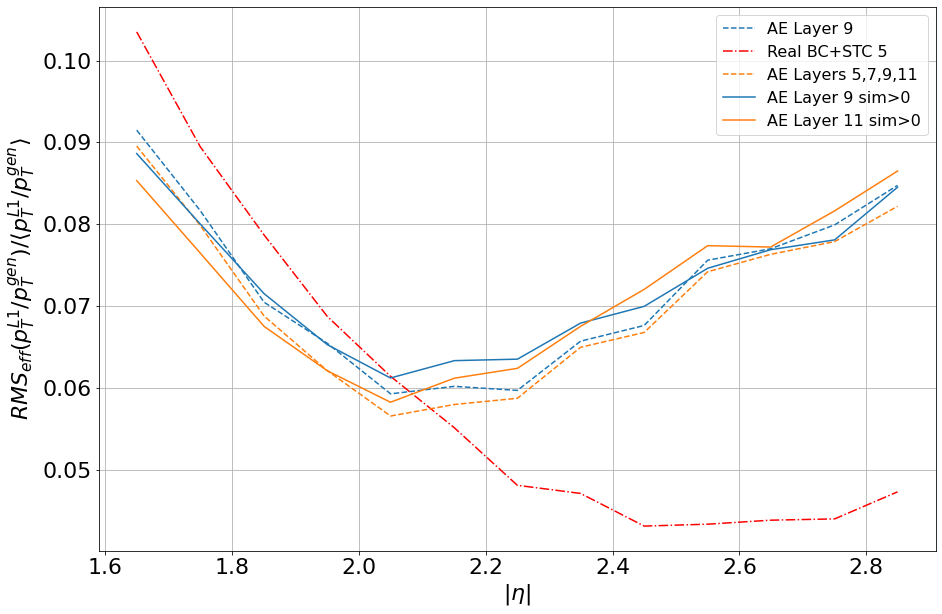

In [24]:
plt.close()
print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
#plt.ylim(0., 0.20)
#plt.axhline(y=0.,color='g',label = 'Ideal', linewidth = 5)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/hack.png',dpi=400)

### For electrons with 200PU, looking at $p_T > 10\,GeV, |\eta| < 2.0$


In [26]:
etameans = {} 
etarmss = {} 
etaeffrmss = {} 
ptmeans = {} 
ptrmss = {} 
pteffrmss = {} 
plot_var = ['genpart_pt', 'genpart_abseta',
            'genpart_bineta', 'genpart_binpt',
           'cl3d_pt', 'cl3d_abseta', 'cl3d_pt_calib',
           'cl3d_pt_corr_eta', 'cl3d_over_gen_pt',
           'calib_over_gen_pt', 'corr_eta_over_gen_pt']
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10 and abs(genpart_abseta)<2')
    etameans[name] = select[plot_var].groupby('genpart_bineta').mean()
    etarmss[name] = select[plot_var].groupby('genpart_bineta').std()
    etaeffrmss[name] = select[plot_var].groupby('genpart_bineta').apply(effrms)
    ptmeans[name] = select[plot_var].groupby('genpart_binpt').mean()
    ptrmss[name] = select[plot_var].groupby('genpart_binpt').std()
    pteffrmss[name] = select[plot_var].groupby('genpart_binpt').apply(effrms)
    #print(etarmss[name])

Mean vs eta


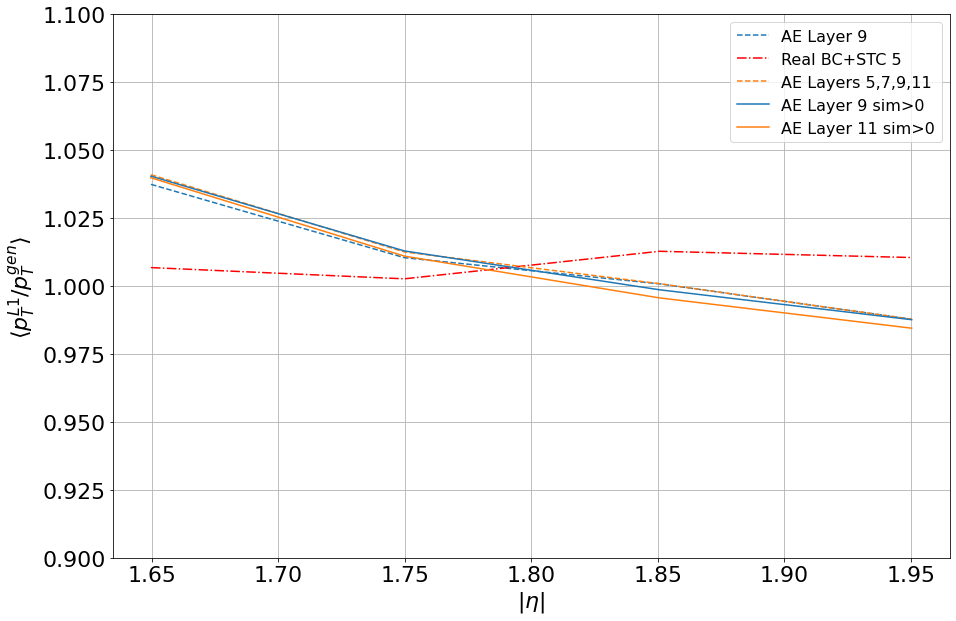

RMS vs eta


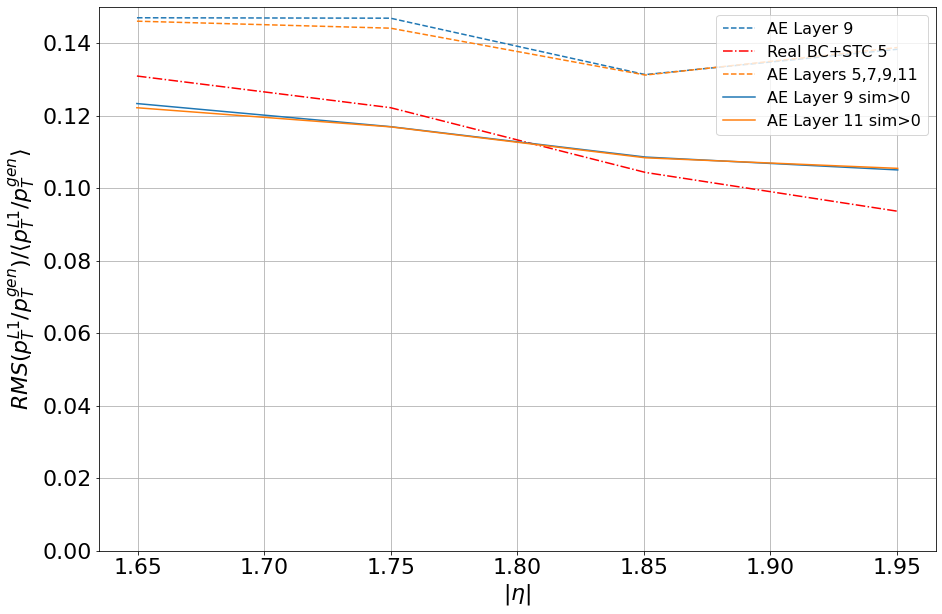

Eff RMS vs eta


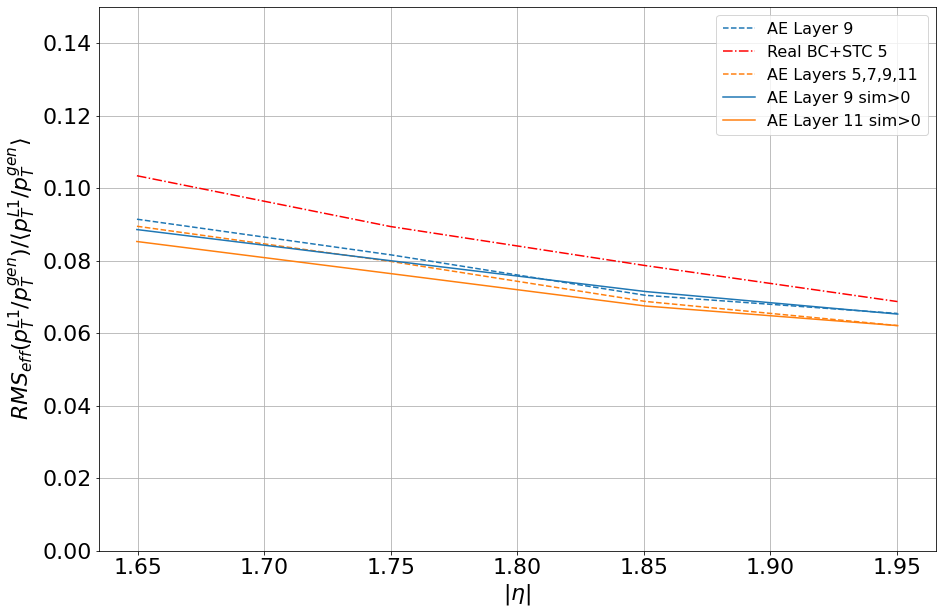

In [27]:
print('Mean vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etarmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.15)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.15)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()

Mean vs pt


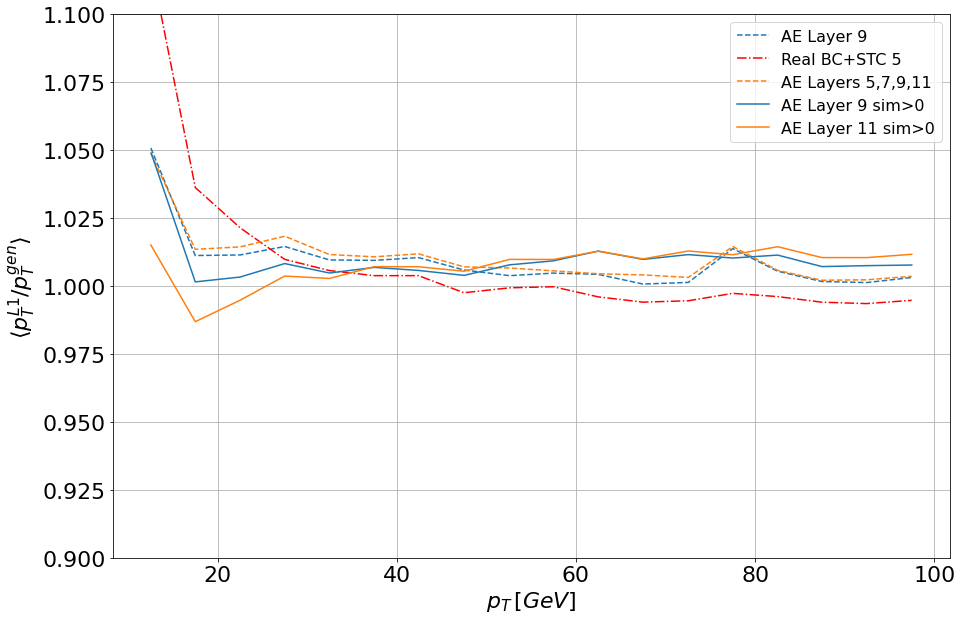

RMS vs pt


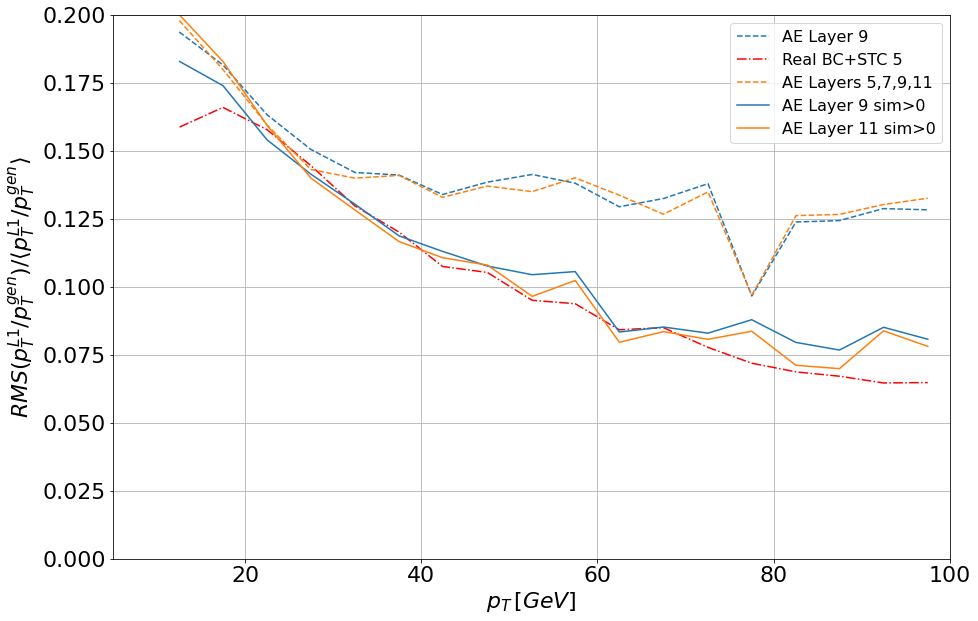

Eff RMS vs pt


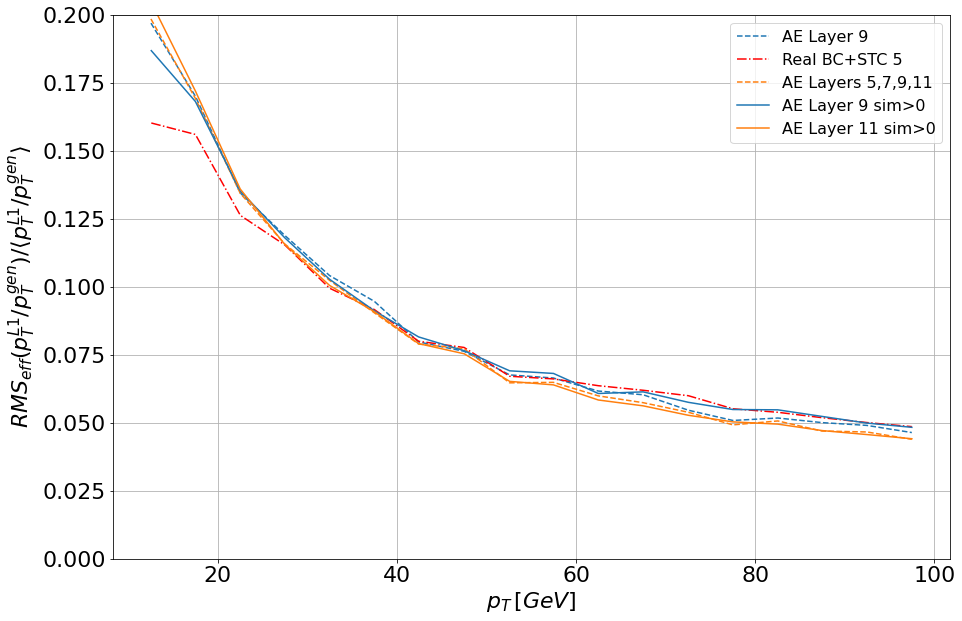

In [28]:
print('Mean vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.xlim(5., 100)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()

### For electrons with 200PU, looking at $p_T > 10\,GeV, |\eta| \in [2.0,2.4]$
First bin in eta and pT

In [29]:
etameans = {} 
etarmss = {} 
etaeffrmss = {} 
ptmeans = {} 
ptrmss = {} 
pteffrmss = {} 
plot_var = ['genpart_pt', 'genpart_abseta',
            'genpart_bineta', 'genpart_binpt',
           'cl3d_pt', 'cl3d_abseta', 'cl3d_pt_calib',
           'cl3d_pt_corr_eta', 'cl3d_over_gen_pt',
           'calib_over_gen_pt', 'corr_eta_over_gen_pt']
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10 and abs(genpart_abseta)<2.4 and abs(genpart_abseta)>2.0')
    etameans[name] = select[plot_var].groupby('genpart_bineta').mean()
    etarmss[name] = select[plot_var].groupby('genpart_bineta').std()
    etaeffrmss[name] = select[plot_var].groupby('genpart_bineta').apply(effrms)
    ptmeans[name] = select[plot_var].groupby('genpart_binpt').mean()
    ptrmss[name] = select[plot_var].groupby('genpart_binpt').std()
    pteffrmss[name] = select[plot_var].groupby('genpart_binpt').apply(effrms)
    #print(etarmss[name])

Mean vs eta


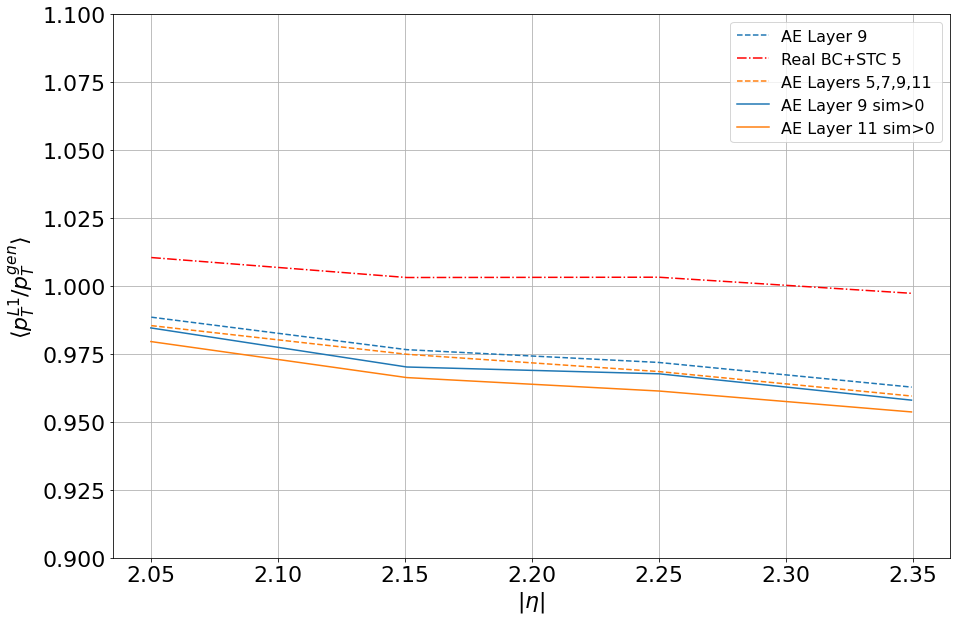

RMS vs eta


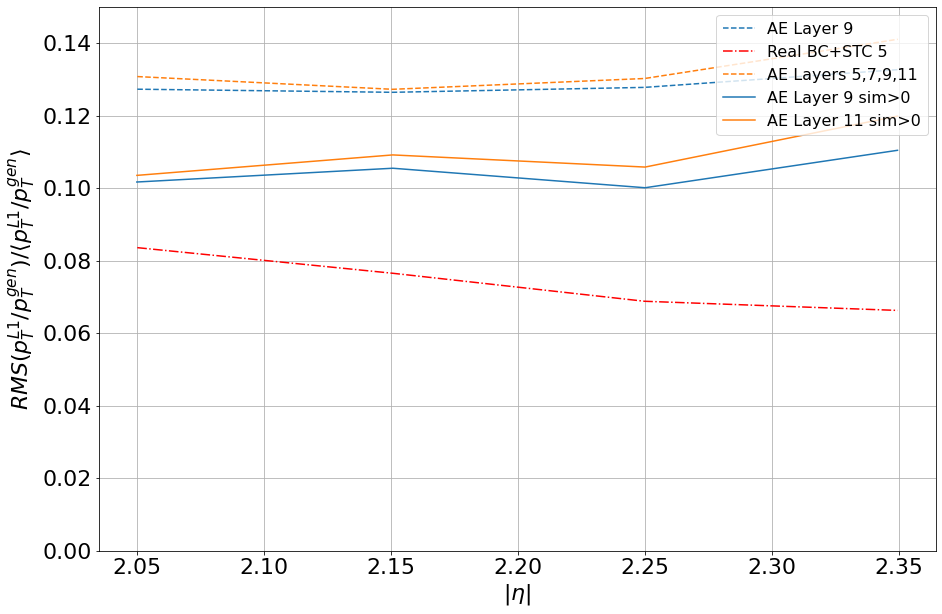

Eff RMS vs eta


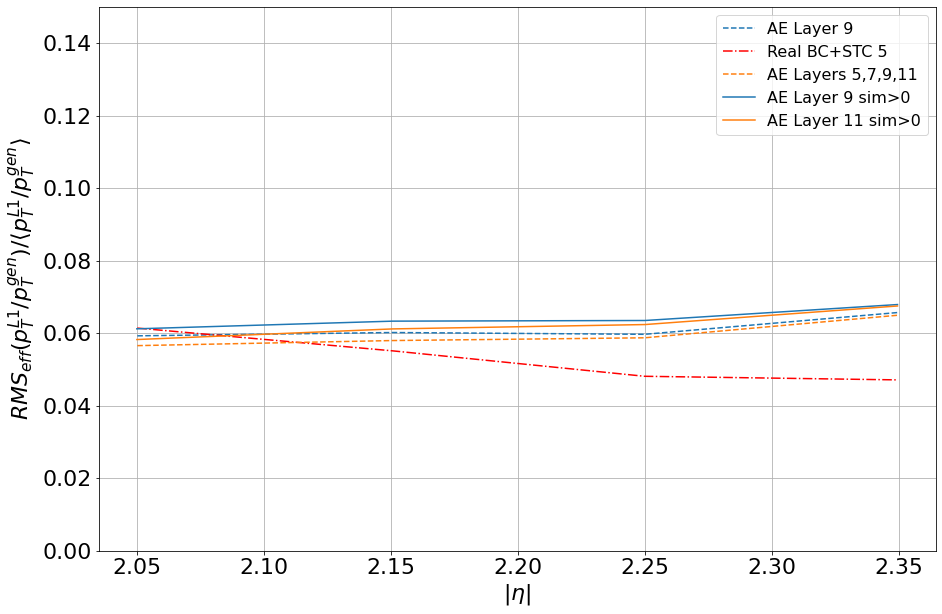

In [30]:
print('Mean vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etarmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.15)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.15)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()

Mean vs pt


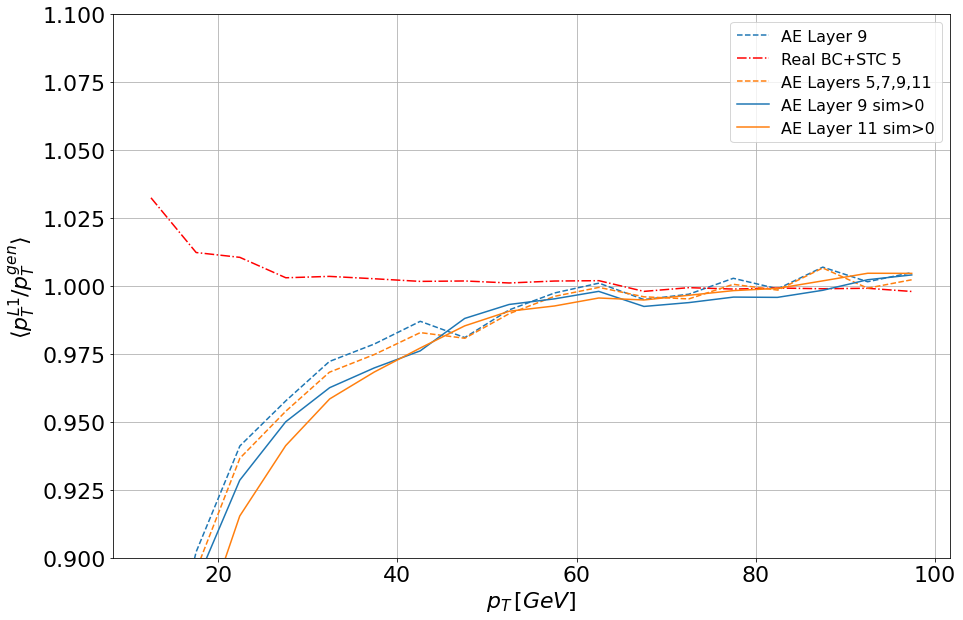

RMS vs pt


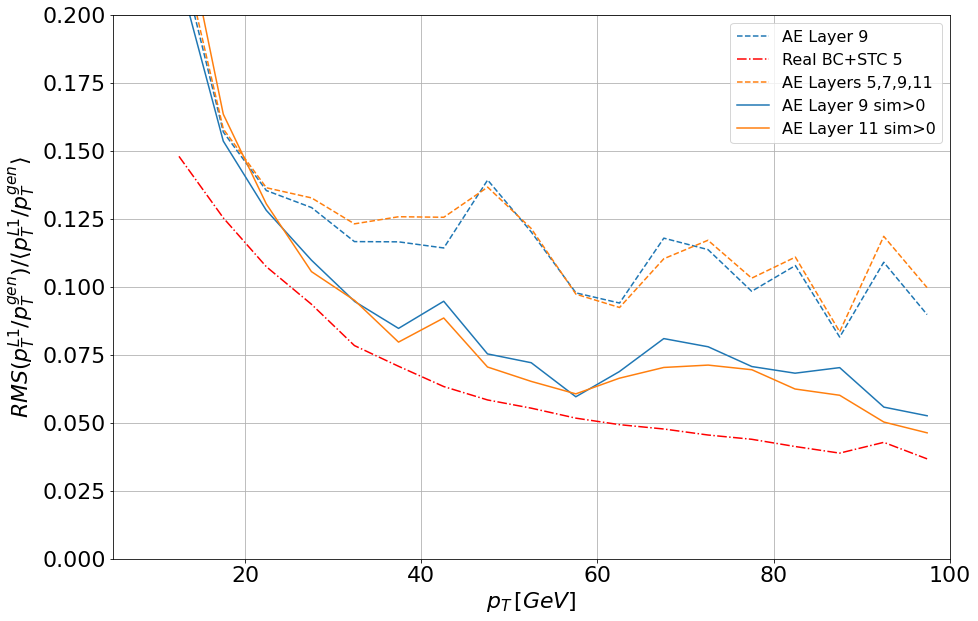

Eff RMS vs pt


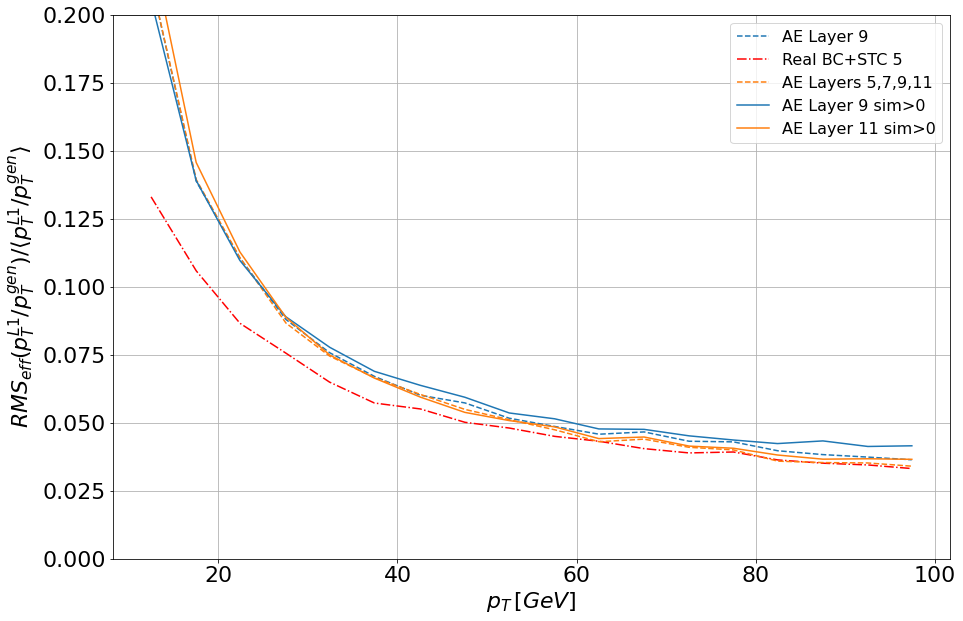

In [31]:
print('Mean vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.xlim(5., 100)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()

### For electrons with 200PU, looking at $p_T > 10\,GeV, |\eta| \in [2.4,2.8]$
First bin in eta and pT

In [32]:
etameans = {} 
etarmss = {} 
etaeffrmss = {} 
ptmeans = {} 
ptrmss = {} 
pteffrmss = {} 
plot_var = ['genpart_pt', 'genpart_abseta',
            'genpart_bineta', 'genpart_binpt',
           'cl3d_pt', 'cl3d_abseta', 'cl3d_pt_calib',
           'cl3d_pt_corr_eta', 'cl3d_over_gen_pt',
           'calib_over_gen_pt', 'corr_eta_over_gen_pt']
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10 and abs(genpart_abseta)<2.8 and abs(genpart_abseta)>2.4')
    etameans[name] = select[plot_var].groupby('genpart_bineta').mean()
    etarmss[name] = select[plot_var].groupby('genpart_bineta').std()
    etaeffrmss[name] = select[plot_var].groupby('genpart_bineta').apply(effrms)
    ptmeans[name] = select[plot_var].groupby('genpart_binpt').mean()
    ptrmss[name] = select[plot_var].groupby('genpart_binpt').std()
    pteffrmss[name] = select[plot_var].groupby('genpart_binpt').apply(effrms)
    #print(etarmss[name])

Mean vs pt


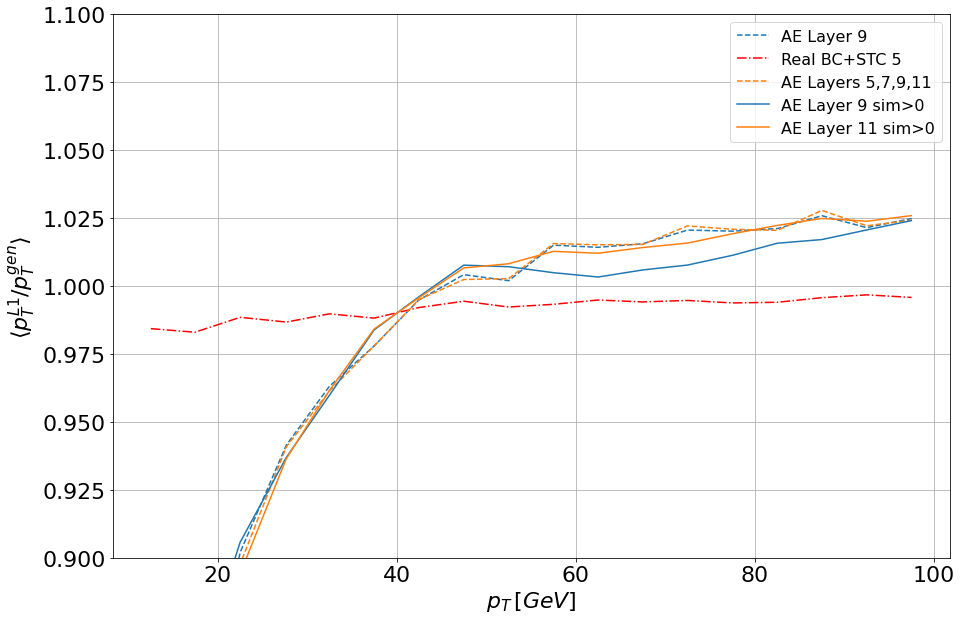

RMS vs pt


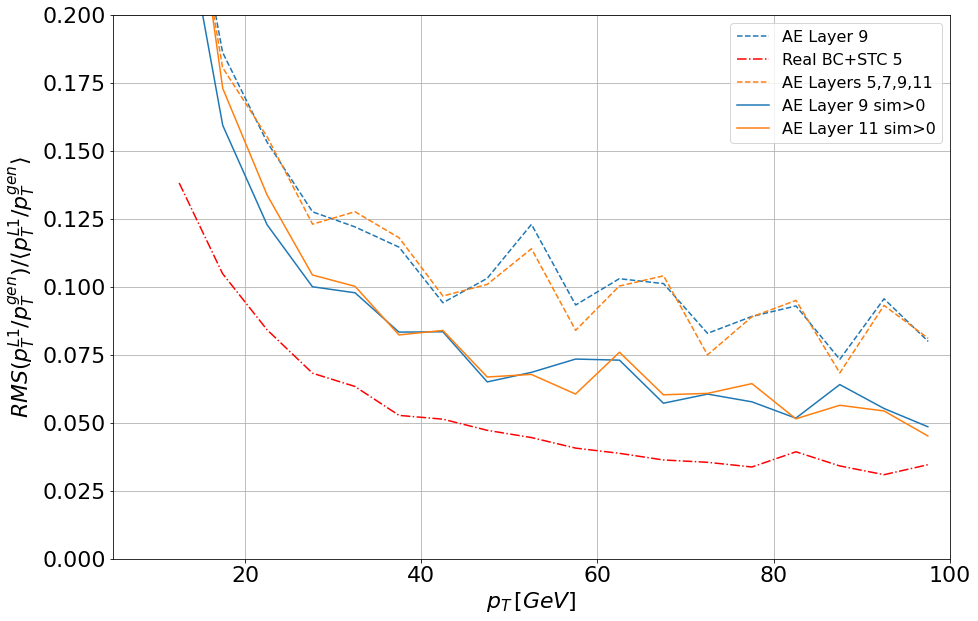

Eff RMS vs pt


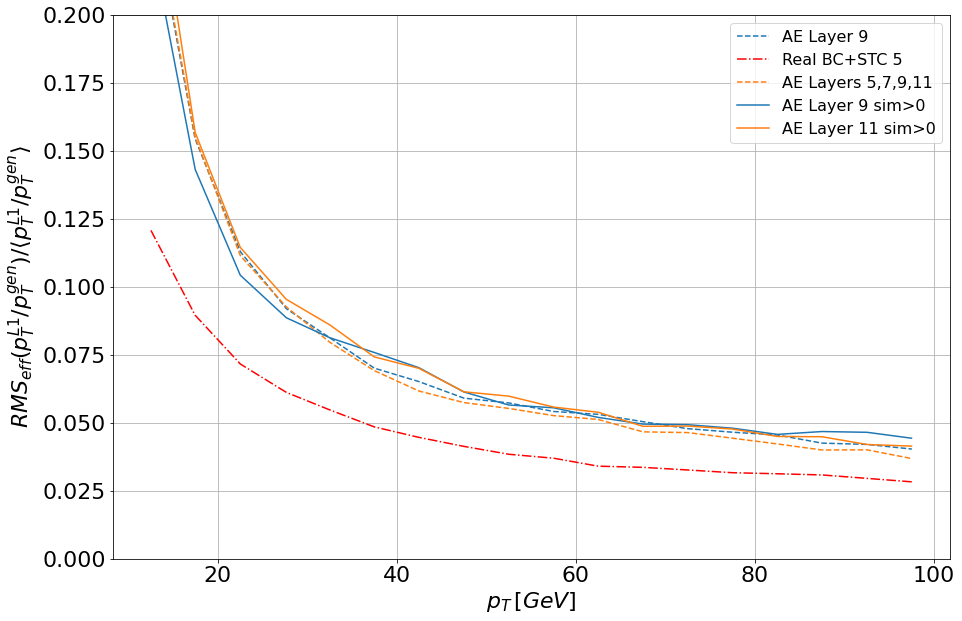

In [33]:
print('Mean vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.xlim(5., 100)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()

In [24]:
#Visualize phase space and relative performance with heatmaps

In [25]:
DENOM=both_eff_rms['Mixedbcstcsig5']['corr_eta_over_gen_pt']/both_means['Mixedbcstcsig5']['corr_eta_over_gen_pt']

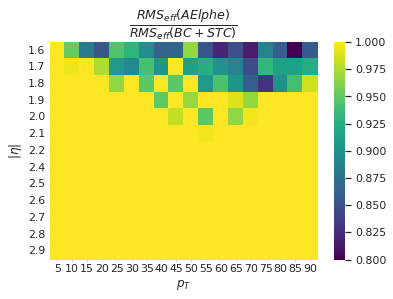

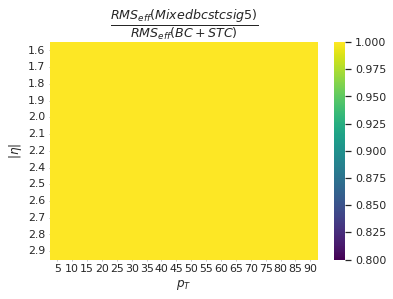

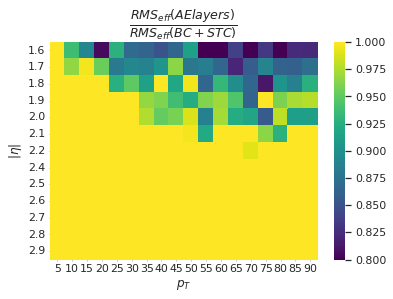

In [26]:
# calculate pt ratio and 68% CI
eta_bins = [f'{neta:0.1f}' for neta in np.linspace(etamin, etamax, 13)]
pt_bins = np.linspace(5, 90, 18).astype(int)

#Individual plots of the ones above: Ratio RMS_eff heatmaps
plt.close()
sns.set(font_scale=1.0)
for ix, (name, df_algo) in enumerate(algo_cut.items()):
    
    fig, axes = plt.subplots()    
    df = ((both_eff_rms[name]['corr_eta_over_gen_pt']/both_means[name]['corr_eta_over_gen_pt'])/DENOM)
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta')
    axes.tick_params(left=True,bottom=True, width =0.5,length=0.8)
    sns.heatmap(df, cmap = 'viridis',
                yticklabels=eta_bins,
                xticklabels = pt_bins,
                vmin=0.8, 
                vmax=1,
                #cbar=bool(ix%2)
               )
    #plt.title(legends[name])
    plt.xlabel(r'$p_{T}$')
    plt.ylabel('$|\eta|$')
    plt.yticks(rotation=0)
    plt.xticks(rotation=0)

    plt.title(r'$\frac{RMS_{eff}('+name+')}{RMS_{eff}(BC+STC)}$',fontsize=18,y=1.03)
    plt.savefig(fig_dir+'/ratio_rms_eff_pt_eta'+name+'.png',dpi=300)
    plt.show()
    df={}

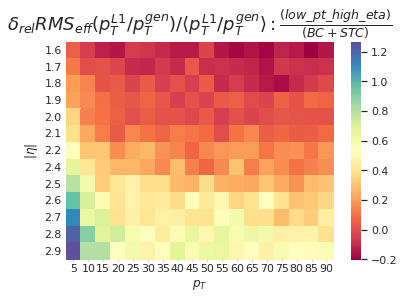

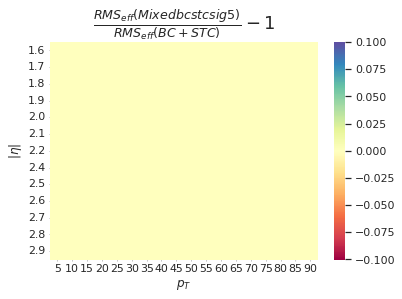

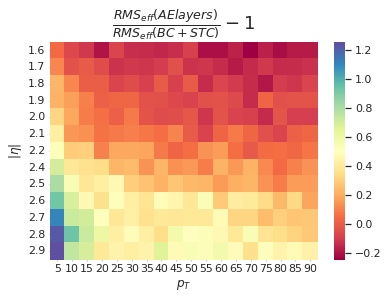

In [27]:
#Individual plots of the ones above: Ratio RMS_eff heatmaps
plt.close()
#sns.set(font_scale=1.0)
for ix, (name, df_algo) in enumerate(algo_cut.items()):
    
    fig, axes = plt.subplots()    
    df = ((both_eff_rms[name]['corr_eta_over_gen_pt']/both_means[name]['corr_eta_over_gen_pt'])/DENOM)-(DENOM/DENOM)
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta')
    axes.tick_params(left=True,bottom=True, width =0.5,length=0.8)
    sns.heatmap(df, cmap = 'Spectral',
                xticklabels=pt_bins,
                yticklabels=eta_bins,
               )
    #plt.title(legends[name])
    plt.xlabel(r'$p_{T}$')
    plt.ylabel('$|\eta|$')
    plt.yticks(rotation=0)
    plt.xticks(rotation=0)
    if name == 'AElphe':
        plt.title(r'$\delta_{rel}RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle:\frac{(low\_pt\_high\_eta)}{(BC+STC)}$',fontsize=18,y=1.03)
        plt.savefig(fig_dir+'/rel_ratio_rms_eff_pt_eta'+name+'.png',dpi=300)
    else:
        plt.title(r'$\frac{RMS_{eff}('+name+')}{RMS_{eff}(BC+STC)}-1$',fontsize=18,y=1.03)
    plt.show()
    df={}

## Storing layer weights and eta corrections for external use

In [28]:
with open(fig_dir+'/layer_weights_photons_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(layer_coeffs, f)
with open(fig_dir+'/lineareta_electrons_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(corrs['eta'], f)